# Modelo de previsão de preços de aluguel da cidade de Nova York

#### Por Thamires Silva - thamirests14@hotmail.com

In [1]:
# Bibliotecas:

# Manipulação dos dados:
import pandas as pd
import numpy as np

# Visualização dos dados: 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Modelagem dos dados:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
 
# Avaliação da performance do modelo:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# Salvar o modelo:
import pickle

# Teste qui² com as variáveis qualitativas:
import scipy
from scipy.stats import chi2_contingency

# Versão dos pacotes:
packages ={'panda':pd.__version__,
           'numpy':np.__version__,
           'seaborn':sns.__version__,
           'matplotlib':matplotlib.__version__,
           'sklearn':sklearn.__version__,
           'pickle':pickle.format_version,
           'scipy': scipy.__version__
          }
packages

{'panda': '2.2.2',
 'numpy': '1.26.4',
 'seaborn': '0.13.2',
 'matplotlib': '3.9.2',
 'sklearn': '1.5.1',
 'pickle': '4.0',
 'scipy': '1.13.1'}

## Pré-processamento de dados

In [2]:
# Importando dados:

data = pd.DataFrame(pd.read_csv("precificacao.csv"))
data.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
# Verificando se há dados duplicados:

data.duplicated(subset='id').sum()

0

In [4]:
# Conforme interesse de negócio, excluindo as colunas: 
#'id', 'nome', 'host_id', 'host_name', 'latitude', 'longitude', 'numero_de_reviews', 
# 'ultima_review', 'reviews_por_mes' e calculado_host_listings_count' 

df = data.drop(columns=['id', 'nome', 'host_id', 'host_name', 'latitude', 'longitude', 'numero_de_reviews', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count' ])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bairro_group         48894 non-null  object
 1   bairro               48894 non-null  object
 2   room_type            48894 non-null  object
 3   price                48894 non-null  int64 
 4   minimo_noites        48894 non-null  int64 
 5   disponibilidade_365  48894 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.2+ MB


Interesse de negócio: Saber o preço de aluguel temporário na cidade de Nova York, não havendo necessidade de se conhecer id's e nomes dos anúncios e dos usuários que os hospedaram no aplicativo da empresa concorrente, bem como o endereço específico das ofertas de alugués e as avaliação de hospedagem que não possuem caráter qualitativos (são avaliações boas ou ruins?).

In [5]:
# Verificando a quantidade de NaNs por coluna:

df.isna().sum()

bairro_group           0
bairro                 0
room_type              0
price                  0
minimo_noites          0
disponibilidade_365    0
dtype: int64

In [6]:
# Deixando a varável de interesse, 'price', em evidência, trazendo-a para a primeira coluna:

df = df.iloc[:, [3, 0, 1, 2, 4, 5]]
df.head()

,price,bairro_group,bairro,room_type,minimo_noites,disponibilidade_365
0,225,Manhattan,Midtown,Entire home/apt,1,355
1,150,Manhattan,Harlem,Private room,3,365
2,89,Brooklyn,Clinton Hill,Entire home/apt,1,194
3,80,Manhattan,East Harlem,Entire home/apt,10,0
4,200,Manhattan,Murray Hill,Entire home/apt,3,129


## Exploratory Data Analysis (EDA)

#### Variáveis quantitativas:

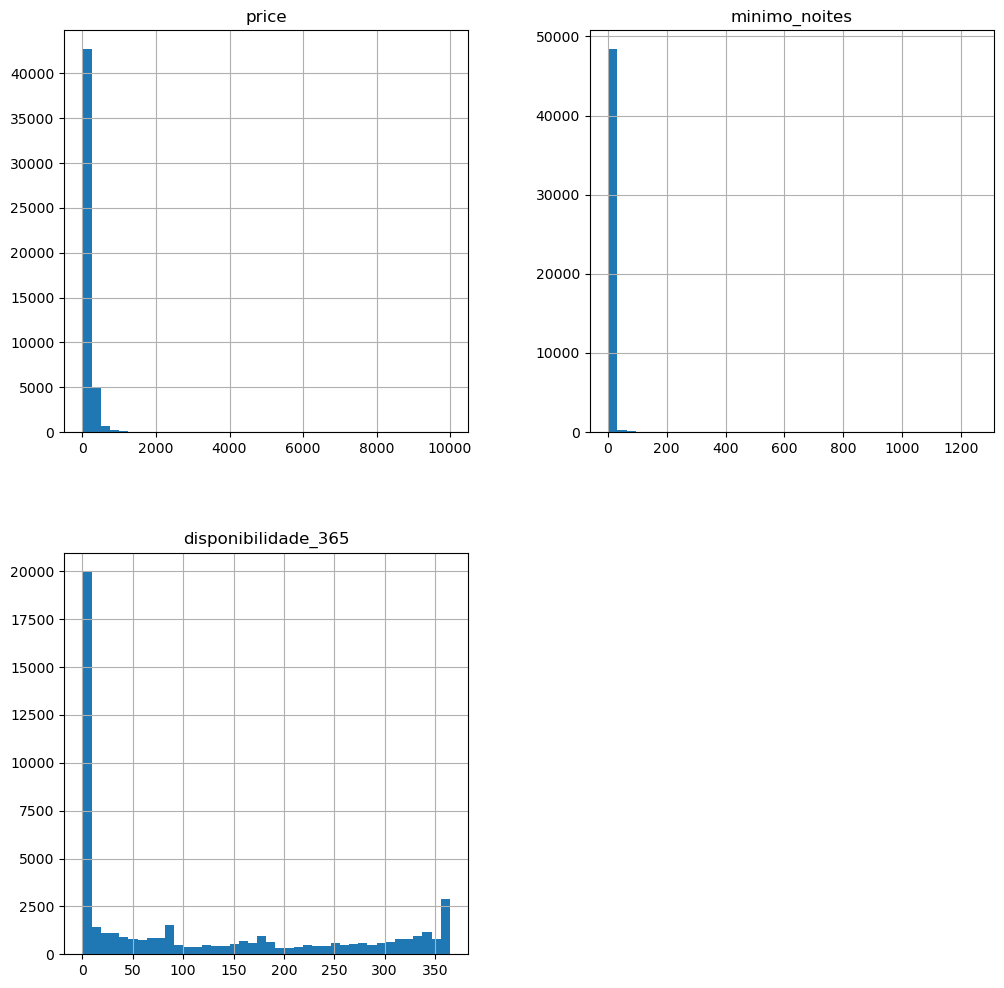

In [7]:
# Overview:

# Histograma:

histograma = df.hist(bins=40, figsize=(12, 12))
plt.savefig('histograma.png', bbox_inches='tight')

Percebe-se que a maior frequência de preços de aluguel está concentrada no lado direito do histograma, indicando maior quantidade de menores preços de aluguel.
O número mínimo de noites que o usuário deve reservar também se concentra no lado direito do gráfico, indicando que as pessoas podem alugar por curtos períodos de tempo. Este fato também é corroborado com o histograma do número de dias em que o anúncio está disponível para reserva, no qual há uma elevada concentração de valores a direita em comparação aos valores mais dispersos ao longo dos dias, demonstrando que há muitas propostas de aluguel para curta temporada, porém há um equilíbrio de ofertas em outros períodos de maior duração.

In [8]:
# Estatística descritiva dos dados:

df.describe()

,price,minimo_noites,disponibilidade_365
count,48894.000000,48894.000000,48894.000000
mean,152.720763,7.030085,112.776169
std,240.156625,20.510741,131.618692
min,0.000000,1.000000,0.000000
25%,69.000000,1.000000,0.000000
50%,106.000000,3.000000,45.000000
75%,175.000000,5.000000,227.000000
max,10000.000000,1250.000000,365.000000


Percebe-se pelas saídas das métricas acima que, a média de preços de aluguel é de 152,72 dólares e 75 por cento dos valores de aluguel são menores que 200 dólares, com anúncios disponíveis em até 227 dias nesse mesmo quartil. Isto confirma que a maior concentração de valores é a de menores preços. 
Quanto ao número mínimo de noites que o usuário deve reservar, pode-se concluir que para 75 por cento da amostra o valor é de até 5 dias, tendo um valor máximo de 1.250 dias (3 anos e meio).
Outro ponto que chama a atenção é o valor mínimo do preço que é de 0 dólar. Esta informação não é passível de análise, uma vez que o interesse de negócio é prever preços de aluguel na cidade de Nova York. Sendo assim, esses valores nulos serão retirados da base de dados.

In [9]:
# Verificando a frequência de observações da coluna 'price' com valores 0:

df['price'].groupby(df['price']).count()

price
0        11
10       17
11        3
12        4
13        1
         ..
7703      1
8000      1
8500      1
9999      3
10000     3
Name: price, Length: 674, dtype: int64

São 11 observações com valor 0.

In [10]:
#Removendo as observações da coluna 'price' com valores 0:

print("Número de observações antes da remoção:", len(df))

[df.drop([i], inplace=True) if df['price'][i] == 0 else df['price'][i] for i in range(0,len(df))]
        
print("Número de observações depois da remoção:", len(df))

Número de observações antes da remoção: 48894
Número de observações depois da remoção: 48883


In [11]:
# Estatística descritiva dos dados, após remoção dos valores nulos:

df.describe()

,price,minimo_noites,disponibilidade_365
count,48883.000000,48883.000000,48883.000000
mean,152.755130,7.030010,112.774339
std,240.172716,20.512416,131.623674
min,10.000000,1.000000,0.000000
25%,69.000000,1.000000,0.000000
50%,106.000000,3.000000,45.000000
75%,175.000000,5.000000,227.000000
max,10000.000000,1250.000000,365.000000


Além do número total de observações ter passado de 48.894 para 48.883, os valores da estatística descritiva não tiveram
mudanças significativas após a remoção dos valores nulos.

### Analisando as interações das variáveis com a coluna 'price'

#### Variáveis quantitativas:

In [12]:
# Separando as variáveis:
# 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count' e 'disponibilidade_365'

df_quant = df.drop(columns=['bairro_group', 'bairro', 'room_type'])
df_quant.head()

,price,minimo_noites,disponibilidade_365
0,225,1,355
1,150,3,365
2,89,1,194
3,80,10,0
4,200,3,129


In [13]:
# Normalizando os valores para ficarem na mesma escala:

normal = MinMaxScaler(feature_range=(-1, 1)) 
normal.fit(df_quant)
df_quant_normal = normal.transform(df_quant)
df_quant_list = list(df_quant.columns)
df_quant_normal = pd.DataFrame(df_quant_normal, columns=df_quant_list)
df_quant_normal.head()

,price,minimo_noites,disponibilidade_365
0,-0.956957,-1.000000,0.945205
1,-0.971972,-0.996797,1.000000
2,-0.984184,-1.000000,0.063014
3,-0.985986,-0.985588,-1.000000
4,-0.961962,-0.996797,-0.293151


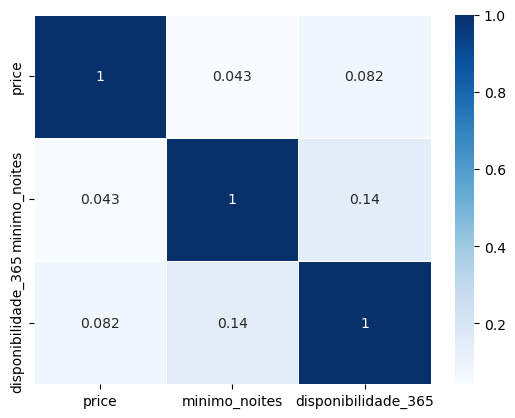

In [14]:
# Correlação de Pearson - Relação linear:

corr = df_quant_normal.corr()

corr_pearson = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap='Blues', annot=True,
        linewidth=.5)

plt.savefig('corr_pearson.png', bbox_inches='tight')

De acordo com os critérios de intervalos do coeficiente de correlação de Pearson (-1, 1), sendo os extremos classificados como correlação muito forte, e valores de 0 a 0,1 (positivo ou negativo), como correlação muito fraca, pode-se concluir que as variáveis quantitativas não interferem no comportamento do preço do aluguel.

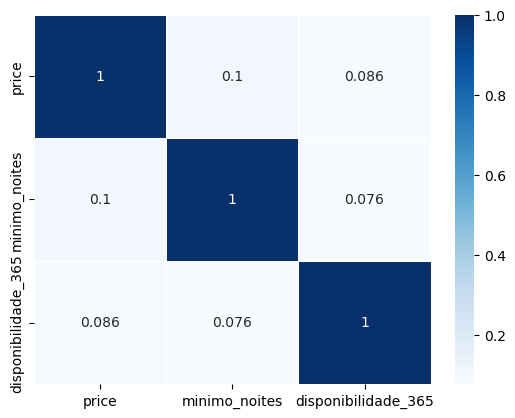

In [15]:
# Correlação de Spearman - Relação não-linear:

corr = df_quant.corr('spearman')

corr_spearman = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap='Blues', annot=True,
        linewidth=.5)

plt.savefig('corr_spearman.png', bbox_inches='tight')

De acordo com os critérios de intervalos do coeficiente de correlação de Spearman (-1, 1), sendo os extremos classificados como correlação muito forte, e valores de 0 a 0,1 (positivo ou negativo), como correlação muito fraca, pode-se concluir que as variáveis quantitativas não interferem no comportamento do preço do aluguel.

Como analisado, para os dois tipos de coeficientes de correlação, as variáveis quantitativas não têm relevância estatística
para justificar o comportamento do preço.

#### Variáveis qualitativas:

In [16]:
# Separando as variáveis:
# 'bairro_group', 'bairro', 'room_type'

df_qual = df.drop(columns=['minimo_noites', 'disponibilidade_365'])
df_qual.head()

,price,bairro_group,bairro,room_type
0,225,Manhattan,Midtown,Entire home/apt
1,150,Manhattan,Harlem,Private room
2,89,Brooklyn,Clinton Hill,Entire home/apt
3,80,Manhattan,East Harlem,Entire home/apt
4,200,Manhattan,Murray Hill,Entire home/apt


In [17]:
# Categorizando os valores da variável 'price':

conditions = [
    (df_qual['price'] >= 10) & (df_qual['price'] < 20),
    (df_qual['price'] >= 20) & (df_qual['price'] < 30),
    (df_qual['price'] >= 30) & (df_qual['price'] < 40),
    (df_qual['price'] >= 40) & (df_qual['price'] < 50),
    (df_qual['price'] >= 50) & (df_qual['price'] < 60),
    (df_qual['price'] >= 60) & (df_qual['price'] < 70),
    (df_qual['price'] >= 70) & (df_qual['price'] < 80),
    (df_qual['price'] >= 80) & (df_qual['price'] < 90),
    (df_qual['price'] >= 90) & (df_qual['price'] < 100),
    (df_qual['price'] >= 100) & (df_qual['price'] < 200),
    (df_qual['price'] >= 200) & (df_qual['price'] < 300),
    (df_qual['price'] >= 300) & (df_qual['price'] < 400),
    (df_qual['price'] >= 400) & (df_qual['price'] < 500),
    (df_qual['price'] >= 500) & (df_qual['price'] < 600),
    (df_qual['price'] >= 600) & (df_qual['price'] < 700),
    (df_qual['price'] >= 700) & (df_qual['price'] < 800),
    (df_qual['price'] >= 800) & (df_qual['price'] < 900),
    (df_qual['price'] >= 900) & (df_qual['price'] < 1000),
    (df_qual['price'] >= 1000) & (df_qual['price'] < 2000),
    (df_qual['price'] >= 2000) & (df_qual['price'] < 3000),
    (df_qual['price'] >= 3000) & (df_qual['price'] < 4000),
    (df_qual['price'] >= 4000) & (df_qual['price'] < 5000),
    (df_qual['price'] >= 5000) & (df_qual['price'] < 6000),
    (df_qual['price'] >= 6000) & (df_qual['price'] < 7000),
    (df_qual['price'] >= 7000) & (df_qual['price'] < 8000),
    (df_qual['price'] >= 8000) & (df_qual['price'] < 9000),
    df_qual['price'] >= 9000
]
choices = [
            '0010-0019',
            '0020-0029',
            '0030-0039',
            '0040-0049',
            '0050-0059',
            '0060-0069',
            '0070-0079',
            '0080-0089',
            '0090-0099',
            '0100-0199',
            '0200-0299',
            '0300-0399',
            '0400-0499',
            '0500-0599',
            '0600-0699',
            '0700-0799',
            '0800-0899',
            '0900-0999',
            '1000-1999',
            '2000-2999',
            '3000-3999',
            '4000-4999',
            '5000-5999',
            '6000-6999',
            '7000-7999',
            '8000-8999',
            'Acima de 9000'
]

# Criando uma nova coluna 'price_category' e trazendo-a variável para a segunda coluna:

df_qual['price_category'] = np.select(conditions, choices)
df_qual = df_qual.iloc[:, [0, 4, 1, 2, 3]]
df_qual.head()

,price,price_category,bairro_group,bairro,room_type
0,225,0200-0299,Manhattan,Midtown,Entire home/apt
1,150,0100-0199,Manhattan,Harlem,Private room
2,89,0080-0089,Brooklyn,Clinton Hill,Entire home/apt
3,80,0080-0089,Manhattan,East Harlem,Entire home/apt
4,200,0200-0299,Manhattan,Murray Hill,Entire home/apt


In [18]:
# Tabelas de contingência:

# Tabela 1: 'price_category' e 'bairro_group'

tabela_1 = pd.crosstab(df_qual['price_category'], df_qual['bairro_group'])
tabela_1

bairro_group,Bronx,Brooklyn,Manhattan,Queens,Staten Island
price_category,,,,,
0010-0019,1,15,15,11,1
0020-0029,54,186,31,71,8
0030-0039,101,863,227,407,40
0040-0049,157,1676,448,668,36
0050-0059,125,1892,766,750,45
0060-0069,135,1931,1026,642,32
0070-0079,111,1679,1087,535,43
0080-0089,88,1367,1152,417,27
0090-0099,50,1286,1283,364,17


Como observado na Tabela 1, os bairros que lideram a maior oferta de anúncios, em ordem decrescente de frequência,
são Manhattan, Brooklyn e Queens, sendo seguidos pelo Bronx em quarto lugar e Staten Island em quinto. Nota-se também que
a oferta de aluguel diminui à medida que o valor do aluguel aumenta na faixa do milhar. 

In [19]:
# Tabela 2: 'price_category' e 'bairro'

tabela_2 = pd.crosstab(df_qual['price_category'], df_qual['bairro'])
tabela_2

bairro,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",...,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside
price_category,,,,,,,,,,,,,,,,,,,,,
0010-0019,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
0020-0029,0,0,0,0,4,0,0,4,0,0,...,0,0,1,6,0,0,1,1,0,1
0030-0039,8,0,7,6,34,1,0,9,1,0,...,0,3,5,23,0,1,12,2,0,33
0040-0049,8,1,0,1,75,3,0,8,0,0,...,1,3,6,144,0,7,19,0,0,39
0050-0059,2,0,1,6,95,4,1,10,0,1,...,0,0,5,251,0,10,16,1,0,41
0060-0069,3,0,3,5,100,1,2,16,0,0,...,0,1,5,383,0,14,15,3,0,18
0070-0079,5,2,1,2,98,0,1,14,0,0,...,0,0,2,362,0,9,4,2,0,15
0080-0089,2,1,0,4,65,1,0,14,0,0,...,0,1,6,290,0,8,5,2,0,14
0090-0099,1,0,0,9,77,3,5,13,2,0,...,0,0,1,298,0,10,5,0,0,13


In [20]:
# Tabela 2: Ordenando os valores de forma decrescente para verificar as 10 áreas com mais oferta de anúncios 
# nos bairros referentes:

tabela_2_10 = pd.DataFrame(tabela_2.sum(axis=0).sort_values(ascending=False))
tabela_2_10['bairro']= tabela_2_10.index.values
tabela_2_10['indice']=range(0,len(tabela_2_10))
tabela_2_10.set_index('indice',inplace=True)
tabela_2_10.rename(columns = {0:'freq',1:'bairro'}, inplace = True)

tabela_2_10 = tabela_2_10[0:10] 
tabela_2_10
bairros = []

[bairros.append(df_qual[df_qual['bairro']==tabela_2_10['bairro'][i]]['bairro_group'].values[0]) for i in range(0,len(tabela_2_10))]
    
tabela_2_10['bairro_group'] = bairros
tabela_2_10 = tabela_2_10.loc[:,['bairro_group','bairro','freq']]
tabela_2_10

,bairro_group,bairro,freq
indice,,,
0,Brooklyn,Williamsburg,3919
1,Brooklyn,Bedford-Stuyvesant,3710
2,Manhattan,Harlem,2658
3,Brooklyn,Bushwick,2462
4,Manhattan,Upper West Side,1971
5,Manhattan,Hell's Kitchen,1958
6,Manhattan,East Village,1853
7,Manhattan,Upper East Side,1798
8,Brooklyn,Crown Heights,1564


Corroborando com a análise da Tabela 1, as áreas com mais ofertas de anúncios de aluguel encontram-se nos bairros Manhattan e Brooklyn.

In [21]:
# Tabela 3: 'price_category' e 'room_type'

tabela_3 = pd.crosstab(df_qual['price_category'], df_qual['room_type'])
tabela_3

room_type,Entire home/apt,Private room,Shared room
price_category,,,
0010-0019,16,13,14
0020-0029,7,182,161
0030-0039,17,1338,283
0040-0049,75,2751,159
0050-0059,173,3317,88
0060-0069,383,3261,122
0070-0079,683,2674,98
0080-0089,942,2065,44
0090-0099,1315,1650,35


Como observado na Tabela 3, aluguel de casa ou apartamento lideram a maior oferta de anúncios, seguido do aluguel de quarto privado em segundo lugar e de quarto compartilhado em terceiro. Corroborando com as análises anteriores, a maior quantidade de ofertas de aluguel são para valores menores de 200 dólares.

In [22]:
# Analisando a significância estatística das associações (teste qui²) ao nível de significância 0,05 ou 5%

# Tabela 1: 'price_category' e 'bairro_group'

chi2, pvalor, dof, freq_esp = chi2_contingency(tabela_1)

print("Associação 1")
print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dof} \n") # graus de liberdade

Associação 1
estatística qui²: 7137.444741028175
p-valor da estatística: 0.0
graus de liberdade: 104 



In [23]:
# Tabela 2: 'price_category' e 'bairro'

chi2, pvalor, dof, freq_esp = chi2_contingency(tabela_2)

print("Associação 2")
print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dof} \n") # graus de liberdade

Associação 2
estatística qui²: 25685.423880267706
p-valor da estatística: 0.0
graus de liberdade: 5720 



In [24]:
# Tabela 3: 'price_category' e 'room_type'

chi2, pvalor, dof, freq_esp = chi2_contingency(tabela_3)

print("Associação 3")
print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dof} \n") # graus de liberdade

Associação 3
estatística qui²: 26564.775059099306
p-valor da estatística: 0.0
graus de liberdade: 52 



O p-valor das 3 associações foi menor que 0,05 ou 5% de nível de significância. Confirmando, assim, que as variáveis 'bairro_group', 'bairro' e 'room_type' apresentam uma associação estatisticamente significativa com a variável 'price'.

## Modelagem dos dados

Para a estratégia de negócio de precificação de aluguéis por região e característica de quarto, será utilizado dois modelos de regressão, Linear e Árvore de Decisão (Não Linear), para verificar qual deles tem o melhor desempenho.

### Preparando os dados

In [25]:
#Como o intuito da análise de negócio é prever o preço de aluguel, a coluna 'price_category' será excluída 
#e as variáveis qualitativas 'bairro_group', 'bairro' e 'room_type' serão transformadas em dummies

df_model = df_qual.drop(columns=['price_category'])
df_model = pd.get_dummies(df_model, columns=['bairro_group', 'bairro', 'room_type'], drop_first=False, dtype=int)
df_model.head()

,price,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,bairro_Allerton,bairro_Arden Heights,bairro_Arrochar,bairro_Arverne,...,bairro_Williamsburg,bairro_Willowbrook,bairro_Windsor Terrace,bairro_Woodhaven,bairro_Woodlawn,bairro_Woodrow,bairro_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,225,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,150,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,89,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,80,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,200,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
# Separando as variáveis dependente (y) e as explicativas (x)

y = df_model['price']
X = df_model.drop(columns=['price'], axis = 1)

# Dividindo a base de dados em treino e teste na proporção 70/30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Definindo as métricas

As métricas escolhidas foram:

Variância (S2): 
- Para verificar a dispersão dos valores em torno de sua média. 
- Quanto maior for seu resultado, mais espalhada é a distribuição.

Raiz do Erro Quadrático Médio (RMSE): 
- Para verificar o desempenho do modelo para dados fora da amostra (distância média que as previsões estarão do alvo, para cima ou para baixo).
- Sensível à presença de outliers que podem distrocer a métrica.
- Quando maior for o resultado, pior é o desempenho do modelo.

Coeficiente de Determinação (R2):
- Para verificar a qualidade de ajuste do modelo.
- Quanto maior for, melhor é a qualidade do ajuste e menor é a variação dos dados em torno de sua média.

In [27]:
## Função que calcula as métricas do performance modelo:

def model_scoring(y_test,y_pred):
    
        series_scoring = pd.Series({'S2': round(metrics.explained_variance_score(y_test, y_pred),4),
                   'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4),
                   'R2': round(metrics.r2_score(y_test, y_pred),4),
                  })
        return series_scoring

metricas=pd.DataFrame(columns = ['S2',
                                'RMSE',
                                'R2'])
metricas_200=pd.DataFrame(columns = ['S2',
                                'RMSE',
                                'R2'])

### Regressão Linear Múltipla

In [28]:
linear_reg=LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

metricas.loc['LinearRegression'] = model_scoring( y_test, y_pred)
metricas

,S2,RMSE,R2
LinearRegression,-1.997724e+18,3.206517e+11,-1.997982e+18


### Árvore de Decisão

In [29]:
decision_tree = DecisionTreeRegressor(random_state=0)
decision_tree.fit(X_train, y_train)
y_pred2 = decision_tree.predict(X_test)

with open('decision_tree.pkl', 'wb') as file:
    pickle.dump(decision_tree, file)

metricas.loc['DecisionTreeRegressor'] = model_scoring( y_test, y_pred2)
metricas

,S2,RMSE,R2
LinearRegression,-1.997724e+18,3.206517e+11,-1.997982e+18
DecisionTreeRegressor,9.570000e-02,2.157426e+02,9.550000e-02


Conforme tabela de métricas, o modelo Regressão Linear não conseguiu explicar a variabilidade dos dados, pois eles não se comportam de forma linear.  Não existem valores negativos no range da variância (S2) e do coeficiente de determinação (R2), além de que a raiz do erro quadrático médio (RMSE) resultou em um valor muito mais elevado do que o próprio valor máximo da base de dados.

Sendo assim, pode-se concluir que os dados têm uma relação não linear. 

Mesmo assim, o modelo de Regressão de Árvore de Decisão não está conseguindo representar o range dos valores de preços de aluguéis. O que pode indicar que a baixa frequência de anúncios com preços elevados (outliers) pode estar interferindo nos resultados. 

Alguns pontos importantes que corroboram com essa hipótese:

- S2: A variância próxima de zero indica que todos os valores de um conjunto de dados são iguais (o que não é o caso).

- RMSE: É sensível à presença de outliers, isso fez com que a distância média das previsões em relação ao alvo fosse maior que 75% da base dados.

- R2: Com valor também próximo ao zero, é possível validar que o modelo não conseguiu explicar a variabilidade dos dados.

Pensando nisso, será refeita a modelagem filtrando os dados de maior frequência que correspondem aos valores menor ou igual a 200 dólares, um pouco mais de 75% da base, utilizando o modelo de Regressão de Árvore de decisão.

### Modelagem dos dados com amostra de preços abaixo de 200 dólares

In [30]:
# Filtrando os dados:

df_filter = df[(df['price'] <= 200)].reset_index()
df_filter = df_filter.drop(columns=['index', 'minimo_noites', 'disponibilidade_365'])

# Transformando as variáveis qualitativas em dummies: 

df_filter_model = pd.get_dummies(df_filter, columns=['bairro_group', 'bairro', 'room_type'], drop_first=False, dtype=int)
df_filter_model.head()

# Separando as variáveis dependente (y) e as explicativas (x)

y2 = df_filter_model['price']
X2 = df_filter_model.drop(columns=['price'], axis = 1)

# Dividindo a base de dados em treino e teste na proporção 70/30

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [31]:
decision_tree2 = DecisionTreeRegressor(random_state=0)
decision_tree2.fit(X_train2, y_train2)
y_pred3 = decision_tree2.predict(X_test2)

with open('decision_tree_200.pkl', 'wb') as file:
    pickle.dump(decision_tree2, file)

metricas_200.loc['DecisionTreeRegressor'] = model_scoring( y_test2, y_pred3)
metricas_200

,S2,RMSE,R2
DecisionTreeRegressor,0.5363,32.3034,0.5363


Com os resultados das performances do modelo, pode-se concluir que os outliers estavam interferindo no ajuste dos dados.

A distribuição dos dados é mais espalhada (S2), a distância média das previsões em relação ao alvo (RMSE) diminuiu em cerca de 15 por cento - representando melhor a população da amostra, e o modelo conseguiu explicar a variabilidade dos dados (R2) em mais de 50 por cento.

O ideal para o cenário de negócio deste projeto não é excluir os valores extremos e, sim, aumentar a quantidade dados com aluguéis acima de 200 dólares, para que não haja outliers, e o modelo consiga performar melhor no range de preços disponíveis e de interesse do cliente. 

## Questões Pertinentes

###### 1.Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Considerando o cenário de que seria mais indicado investir onde o preço do aluguel por noite seja elevado, com o mínimo de noites que o usuário deve reservar sendo o valor máximo e que o anúncio esteja disponível o ano todo, tem-se que:

In [32]:
q1 = df.copy()
q1 = q1.sort_values('price', ascending=False)
q1 = q1[(q1['room_type'] == 'Entire home/apt')]
q1 = q1[(q1['minimo_noites'] <= 1250)]
q1 = q1[(q1['disponibilidade_365'] == 365)]
q1.head(1)

,price,bairro_group,bairro,room_type,minimo_noites,disponibilidade_365
40432,9999,Manhattan,Lower East Side,Entire home/apt,30,365


O local indicado é a área de Lower East Side no bairro Manhattan com aluguel por noite de 9.999 dólares.

###### 2.O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço? 

Não interferem, pois são estatisticamente irrelevantes para explicar o comportamento do preço. 

###### 3.Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [33]:
q3 = df.copy()
q3 = q3.sort_values('price', ascending=False)
q3 = q3[(q3['price'] >= 1000)]
q3.head()

,price,bairro_group,bairro,room_type,minimo_noites,disponibilidade_365
9150,10000,Queens,Astoria,Private room,100,0
29237,10000,Manhattan,Upper West Side,Entire home/apt,30,83
17691,10000,Brooklyn,Greenpoint,Entire home/apt,5,0
40432,9999,Manhattan,Lower East Side,Entire home/apt,30,365
6529,9999,Manhattan,East Harlem,Entire home/apt,5,0


In [34]:
# Categorizando os valores da variável 'price':

conditions = [(q3['price'] >= 1000)]
choices = ['1.000-10.000']

# Criando uma nova coluna 'price_category' e trazendo-a variável para a segunda coluna:

q3['price_category'] = np.select(conditions, choices)
q3 = q3.drop(columns=['price', 'minimo_noites', 'disponibilidade_365'])
q3 = q3.iloc[:, [3, 0, 1, 2]]
q3.head()

,price_category,bairro_group,bairro,room_type
9150,1.000-10.000,Queens,Astoria,Private room
29237,1.000-10.000,Manhattan,Upper West Side,Entire home/apt
17691,1.000-10.000,Brooklyn,Greenpoint,Entire home/apt
40432,1.000-10.000,Manhattan,Lower East Side,Entire home/apt
6529,1.000-10.000,Manhattan,East Harlem,Entire home/apt


In [35]:
tabela_bg = pd.crosstab(q3['price_category'], q3['bairro_group'])
tabela_bg.sort_values(ascending=False, inplace=True, axis = 1,by='1.000-10.000')
tabela_bg

bairro_group,Manhattan,Brooklyn,Queens,Staten Island,Bronx
price_category,,,,,
1.000-10.000,213,67,13,3,2


In [36]:
tabela_b = pd.crosstab(q3['price_category'], q3['bairro'])
tabela_b.sort_values(ascending=False, inplace=True, axis = 1,by='1.000-10.000')
tabela_b

bairro,Upper West Side,Midtown,Tribeca,Upper East Side,Chelsea,West Village,East Village,Bedford-Stuyvesant,Williamsburg,SoHo,...,Jamaica,Greenpoint,Fort Greene,Forest Hills,Flatlands,East Flatbush,Cypress Hills,Columbia St,City Island,Arverne
price_category,,,,,,,,,,,,,,,,,,,,,
1.000-10.000,30,23,17,16,15,15,14,13,12,10,...,1,1,1,1,1,1,1,1,1,1


O bairro com lugares de mais alto valor é Manhattan.

###### 5.Supondo um apartamento com as seguintes características:

In [37]:
{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

###### Qual seria o valor do preço do aluguel?

In [38]:
alug = {'id': 2595,
        'nome': 'Skylit Midtown Castle',
        'host_id': 2845,
        'host_name': 'Jennifer',
        'bairro_group': 'Manhattan',
        'bairro': 'Midtown',
        'latitude': 40.75362,
        'longitude': -73.98377,
        'room_type': 'Entire home/apt',
        'minimo_noites': 1,
        'numero_de_reviews': 45,
        'ultima_review': '2019-05-21',
        'reviews_por_mes': 0.38,
        'calculado_host_listings_count': 2,
        'disponibilidade_365': 355}

# Deixando apenas as variáveis relevantes para a previsão do preço de aluguel: 'bairro_group', 'bairro' e 'room_type'

alug = pd.DataFrame(alug, index=[0])
alug = alug.drop(columns=['id', 'nome', 'host_id', 'host_name', 'latitude', 'longitude', 'ultima_review','minimo_noites', 'numero_de_reviews', 'reviews_por_mes','calculado_host_listings_count', 'disponibilidade_365'])

# Transformando as variáveis 'bairro_group', 'bairro' e 'room_type' em dummies

alug = pd.get_dummies(alug, columns=['bairro_group', 'bairro', 'room_type'], drop_first=False, dtype=int)
alug.head()

,bairro_group_Manhattan,bairro_Midtown,room_type_Entire home/apt
0,1,1,1


In [39]:
# Aumentando a proporção do dataframe para corresponder a proporção do dataframe do modelo

aluguel_prop = []
[aluguel_prop.append(1) if i in alug.columns else aluguel_prop.append(0) for i in X.columns]
aluguel = pd.DataFrame(columns=X.columns)
aluguel.loc[0] = aluguel_prop

aluguel_prop2 = []
[aluguel_prop2.append(1) if i in alug.columns else aluguel_prop2.append(0) for i in X2.columns]     
aluguel2 = pd.DataFrame(columns=X2.columns)
aluguel2.loc[0] = aluguel_prop2

A previsão do valor do aluguel será realizada com os dois modelos de Árvore de Decisão (com a quantidade total de preços e com os de valores menor ou igual a 200 dólares), a fim de verificar se há diferença significativa entre os resultados. 

In [40]:
# Previsão:

prev_aluguel = decision_tree.predict(aluguel)
print(round(prev_aluguel[0]))
prev_aluguel2 = decision_tree2.predict(aluguel2)
print(round(prev_aluguel2[0]))

300
157


Para a base total, o preço do aluguel seria de 300 dólares.

Para a base menor ou igual a 200 dólares, o preço do aluguel seria de 157 dólares.